# Week 10

## Kinnick Fox
## DSC530

All code before Exercise 12-1 is written by Allen B. Downey


In [3]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)

download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/mj-clean.csv")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [19]:
import numpy as np
import pandas as pd

import random

import thinkstats2
import thinkplot

import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from IPython.display import display
import statsmodels.tsa.stattools as smtsa

In [10]:
def GroupByDay(transactions, func=np.mean):
    """Groups transactions by day and compute the daily mean ppg.

    transactions: DataFrame of transactions

    returns: DataFrame of daily prices
    """
    grouped = transactions[["date", "ppg"]].groupby("date")
    daily = grouped.aggregate(func)

    daily["date"] = daily.index
    start = daily.date[0]
    one_year = np.timedelta64(1, "Y")
    daily["years"] = (daily.date - start) / one_year

    return daily

In [11]:
def GroupByQualityAndDay(transactions):
    """Divides transactions by quality and computes mean daily price.

    transaction: DataFrame of transactions

    returns: map from quality to time series of ppg
    """
    groups = transactions.groupby("quality")
    dailies = {}
    for name, group in groups:
        dailies[name] = GroupByDay(group)

    return dailies

In [33]:
transactions = pd.read_csv("mj-clean.csv", parse_dates=[5])
dailies = GroupByQualityAndDay(transactions)

In [12]:
def RunLinearModel(daily):
    model = smf.ols("ppg ~ years", data=daily)
    results = model.fit()
    return model, results

In [37]:
def PlotFittedValues(model, results, label=""):
    """Plots original data and fitted values.

    model: StatsModel model object
    results: StatsModel results object
    """
    years = model.exog[:, 1]
    values = model.endog
    thinkplot.Scatter(years, values, s=15, label=label)
    thinkplot.Plot(years, results.fittedvalues, label="model", color="#ff7f00")

In [13]:
def PlotLinearModel(daily, name):
    """Plots a linear fit to a sequence of prices, and the residuals.

    daily: DataFrame of daily prices
    name: string
    """
    model, results = RunLinearModel(daily)
    PlotFittedValues(model, results, label=name)
    thinkplot.Config(
        title="Fitted values",
        xlabel="Years",
        xlim=[-0.1, 3.8],
        ylabel="Price per gram ($)",
    )

In [14]:
def PlotRollingMean(daily, name):
    """Plots rolling mean.

    daily: DataFrame of daily prices
    """
    dates = pd.date_range(daily.index.min(), daily.index.max())
    reindexed = daily.reindex(dates)

    thinkplot.Scatter(reindexed.ppg, s=15, alpha=0.2, label=name)
    roll_mean = pd.Series(reindexed.ppg).rolling(30).mean()
    thinkplot.Plot(roll_mean, label="rolling mean", color="#ff7f00")
    plt.xticks(rotation=30)
    thinkplot.Config(ylabel="price per gram ($)")

In [15]:
def PlotEWMA(daily, name):
    """Plots rolling mean.

    daily: DataFrame of daily prices
    """
    dates = pd.date_range(daily.index.min(), daily.index.max())
    reindexed = daily.reindex(dates)

    thinkplot.Scatter(reindexed.ppg, s=15, alpha=0.2, label=name)
    roll_mean = reindexed.ppg.ewm(30).mean()
    thinkplot.Plot(roll_mean, label="EWMA", color="#ff7f00")
    plt.xticks(rotation=30)
    thinkplot.Config(ylabel="price per gram ($)")

In [16]:
def FillMissing(daily, span=30):
    """Fills missing values with an exponentially weighted moving average.

    Resulting DataFrame has new columns 'ewma' and 'resid'.

    daily: DataFrame of daily prices
    span: window size (sort of) passed to ewma

    returns: new DataFrame of daily prices
    """
    dates = pd.date_range(daily.index.min(), daily.index.max())
    reindexed = daily.reindex(dates)

    ewma = pd.Series(reindexed.ppg).ewm(span=span).mean()

    resid = (reindexed.ppg - ewma).dropna()
    fake_data = ewma + thinkstats2.Resample(resid, len(reindexed))
    reindexed.ppg.fillna(fake_data, inplace=True)

    reindexed["ewma"] = ewma
    reindexed["resid"] = reindexed.ppg - ewma
    return reindexed

In [17]:
def PlotFilled(daily, name):
    """Plots the EWMA and filled data.

    daily: DataFrame of daily prices
    """
    filled = FillMissing(daily, span=30)
    thinkplot.Scatter(filled.ppg, s=15, alpha=0.2, label=name)
    thinkplot.Plot(filled.ewma, label="EWMA", color="#ff7f00")
    plt.xticks(rotation=30)
    thinkplot.Config(ylabel="Price per gram ($)")

In [18]:
def SerialCorr(series, lag=1):
    xs = series[lag:]
    ys = series.shift(lag)[lag:]
    corr = thinkstats2.Corr(xs, ys)
    return corr

In [20]:
def SimulateAutocorrelation(daily, iters=1001, nlags=40):
    """Resample residuals, compute autocorrelation, and plot percentiles.

    daily: DataFrame
    iters: number of simulations to run
    nlags: maximum lags to compute autocorrelation
    """
    # run simulations
    t = []
    for _ in range(iters):
        filled = FillMissing(daily, span=30)
        resid = thinkstats2.Resample(filled.resid)
        acf = smtsa.acf(resid, nlags=nlags, fft=False)[1:]
        t.append(np.abs(acf))

    high = thinkstats2.PercentileRows(t, [97.5])[0]
    low = -high
    lags = range(1, nlags + 1)
    thinkplot.FillBetween(lags, low, high, alpha=0.2, color="gray")

In [21]:
def PlotAutoCorrelation(dailies, nlags=40, add_weekly=False):
    """Plots autocorrelation functions.

    dailies: map from category name to DataFrame of daily prices
    nlags: number of lags to compute
    add_weekly: boolean, whether to add a simulated weekly pattern
    """
    thinkplot.PrePlot(3)
    daily = dailies["high"]
    SimulateAutocorrelation(daily)

    for name, daily in dailies.items():

        if add_weekly:
            daily.ppg = AddWeeklySeasonality(daily)

        filled = FillMissing(daily, span=30)

        acf = smtsa.acf(filled.resid, nlags=nlags, fft=False)
        lags = np.arange(len(acf))
        thinkplot.Plot(lags[1:], acf[1:], label=name)

In [22]:
def AddWeeklySeasonality(daily):
    """Adds a weekly pattern.

    daily: DataFrame of daily prices

    returns: new DataFrame of daily prices
    """
    fri_or_sat = (daily.index.dayofweek == 4) | (daily.index.dayofweek == 5)
    fake = daily.ppg.copy()
    fake[fri_or_sat] += np.random.uniform(0, 2, fri_or_sat.sum())
    return fake

In [23]:
def GenerateSimplePrediction(results, years):
    """Generates a simple prediction.

    results: results object
    years: sequence of times (in years) to make predictions for

    returns: sequence of predicted values
    """
    n = len(years)
    inter = np.ones(n)
    d = dict(Intercept=inter, years=years, years2=years**2)
    predict_df = pd.DataFrame(d)
    predict = results.predict(predict_df)
    return predict

In [24]:
def PlotSimplePrediction(results, years):
    predict = GenerateSimplePrediction(results, years)

    thinkplot.Scatter(daily.years, daily.ppg, alpha=0.2, label=name)
    thinkplot.plot(years, predict, color="#ff7f00")
    xlim = years[0] - 0.1, years[-1] + 0.1
    thinkplot.Config(
        title="Predictions",
        xlabel="Years",
        xlim=xlim,
        ylabel="Price per gram ($)",
        loc="upper right",
    )

In [25]:
def SimulateResults(daily, iters=101, func=RunLinearModel):
    """Run simulations based on resampling residuals.

    daily: DataFrame of daily prices
    iters: number of simulations
    func: function that fits a model to the data

    returns: list of result objects
    """
    _, results = func(daily)
    fake = daily.copy()

    result_seq = []
    for _ in range(iters):
        fake.ppg = results.fittedvalues + thinkstats2.Resample(results.resid)
        _, fake_results = func(fake)
        result_seq.append(fake_results)

    return result_seq

In [26]:
def GeneratePredictions(result_seq, years, add_resid=False):
    """Generates an array of predicted values from a list of model results.

    When add_resid is False, predictions represent sampling error only.

    When add_resid is True, they also include residual error (which is
    more relevant to prediction).

    result_seq: list of model results
    years: sequence of times (in years) to make predictions for
    add_resid: boolean, whether to add in resampled residuals

    returns: sequence of predictions
    """
    n = len(years)
    d = dict(Intercept=np.ones(n), years=years, years2=years**2)
    predict_df = pd.DataFrame(d)

    predict_seq = []
    for fake_results in result_seq:
        predict = fake_results.predict(predict_df)
        if add_resid:
            predict += thinkstats2.Resample(fake_results.resid, n)
        predict_seq.append(predict)

    return predict_seq

In [27]:
def PlotPredictions(daily, years, iters=101, percent=90, func=RunLinearModel):
    """Plots predictions.

    daily: DataFrame of daily prices
    years: sequence of times (in years) to make predictions for
    iters: number of simulations
    percent: what percentile range to show
    func: function that fits a model to the data
    """
    result_seq = SimulateResults(daily, iters=iters, func=func)
    p = (100 - percent) / 2
    percents = p, 100 - p

    predict_seq = GeneratePredictions(result_seq, years, add_resid=True)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.3, color="gray")

    predict_seq = GeneratePredictions(result_seq, years, add_resid=False)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.5, color="gray")

In [28]:
def SimulateIntervals(daily, iters=101, func=RunLinearModel):
    """Run simulations based on different subsets of the data.

    daily: DataFrame of daily prices
    iters: number of simulations
    func: function that fits a model to the data

    returns: list of result objects
    """
    result_seq = []
    starts = np.linspace(0, len(daily), iters).astype(int)

    for start in starts[:-2]:
        subset = daily[start:]
        _, results = func(subset)
        fake = subset.copy()

        for _ in range(iters):
            fake.ppg = results.fittedvalues + thinkstats2.Resample(results.resid)
            _, fake_results = func(fake)
            result_seq.append(fake_results)

    return result_seq

In [29]:
def PlotIntervals(daily, years, iters=101, percent=90, func=RunLinearModel):
    """Plots predictions based on different intervals.

    daily: DataFrame of daily prices
    years: sequence of times (in years) to make predictions for
    iters: number of simulations
    percent: what percentile range to show
    func: function that fits a model to the data
    """
    result_seq = SimulateIntervals(daily, iters=iters, func=func)
    p = (100 - percent) / 2
    percents = p, 100 - p

    predict_seq = GeneratePredictions(result_seq, years, add_resid=True)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.2, color="gray")

## Exercises

**Exercise 12-1:**   The linear model I used in this chapter has the obvious drawback that it is linear, and there is no reason to expect prices to change linearly over time. We can add flexibility to the model by adding a quadratic term, as we did in Section 11.3.

Use a quadratic model to fit the time series of daily prices, and use the model to generate predictions. You will have to write a version of `RunLinearModel` that runs that quadratic model, but after that you should be able to reuse code from the chapter to generate predictions.

In [47]:
def RunQuadModel(data):
    # Modified RunLinearModel adding years2 to model
    data["years2"] = data.years**2
    model = smf.ols("ppg ~ years + years2", data=data)
    results = model.fit()
    return model, results

In [41]:
day_high = dailies["high"]
model, results = RunQuadModel(day_high)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ppg   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     517.5
Date:                Sat, 18 Feb 2023   Prob (F-statistic):          4.57e-164
Time:                        11:25:29   Log-Likelihood:                -1497.4
No. Observations:                1241   AIC:                             3001.
Df Residuals:                    1238   BIC:                             3016.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.6980      0.067    205.757      0.000      13.567      13.829
years         -1.1171      0.084    -13.326      0.000      -1.282      -0.953
years2         0.1132      0.022      5.060      0.000       0.069       0.157
==============================================================================
Omnibus:                       49.112   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.885
Skew:                           0.199   Prob(JB):                     1.86e-25
Kurtosis:                       4.430   Cond. No.                         27.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

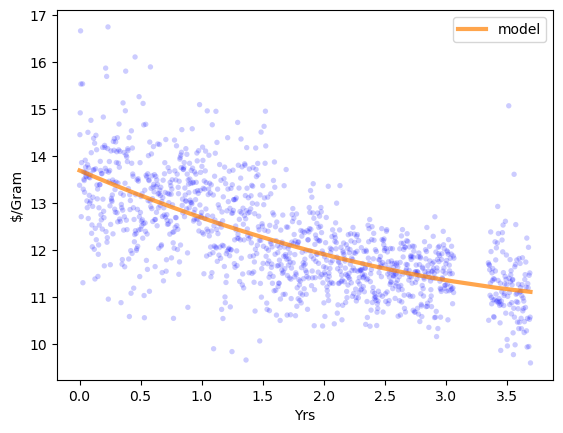

In [42]:
PlotFittedValues(model, results)
thinkplot.Config(xlabel="Yrs", ylabel="$/Gram")

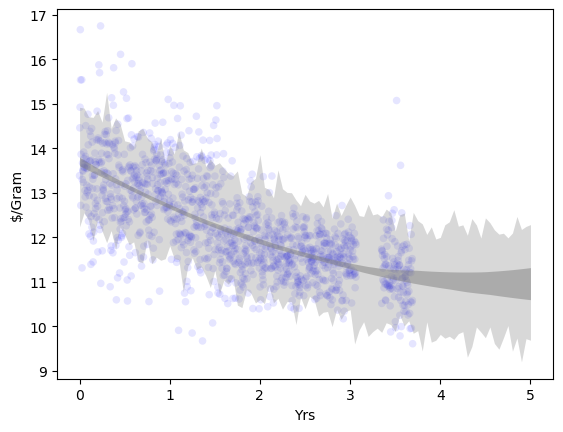

In [46]:
yrs = np.linspace(0, 5, 101)
thinkplot.Scatter(day_high.years, day_high.ppg, alpha=0.1)
PlotPredictions(day_high, yrs, func=RunQuadModel)
thinkplot.Config(xlabel="Yrs",ylabel="$/Gram")

**Exercise 12-2:** Write a definition for a class named `SerialCorrelationTest` that extends `HypothesisTest` from Section 9.2. It should take a series and a lag as data, compute the serial correlation of the series with the given lag, and then compute the p-value of the observed correlation.

Use this class to test whether the serial correlation in raw price data is statistically significant. Also test the residuals of the linear model and (if you did the previous exercise), the quadratic model.

In [54]:
class SerialCorrelationTest(thinkstats2.HypothesisTest):
    
    def TestStatistic(self, data):
        series, lag = data
        return abs(SerialCorr(series, lag))

    def RunModel(self):
        series, lag = self.data
        permutation = series.reindex(np.random.permutation(series.index))
        return permutation, lag

In [56]:
day_high = dailies["high"]

series = day_high.ppg
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print(test.actual, pvalue)

0.4852293761947381 0.0


In [58]:
_, results = RunLinearModel(day_high)
series = results.resid
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print(test.actual, pvalue)

0.07570473767506261 0.008


In [59]:
_, results = RunQuadModel(day_high)
series = results.resid
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print(test.actual, pvalue)

0.0560730816128992 0.056
